<left>FINM 33150 - Quantitative Trading Strategies</left>
<left>Winter 2023</left>
<br>
<h1><center> Homework 6: Predictive Regression </center></h1>
<center>Due - 23:00 [CST] February 17, 2023</center>
<br>
<h3>Ki Hyun</h3>
<h3>Student ID: 12125881</h3>

<h5> Imports </h5>

In [1]:
%matplotlib inline

In [2]:
import os
from datetime import datetime, timedelta
import quandl
import pandas as pd
import numpy as np
from numpy.linalg import inv
from statsmodels.regression import linear_model as lm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

<h5> Constants </h5>

In [3]:
Prices_table = 'QUOTEMEDIA/PRICES'
CDS_table = os.path.join(r'C:\Users\kwhyu\OneDrive - The University of Chicago\2023-1 Winter\FINM 33150\FINM-33150-W23',
                         r'Data\CDS\Liq5YCDS.delim')
K = 16
half_life = 12

<h5> Helper Functions </h5>

In [4]:
"""
This code was given by Dr. Boonstra, B., Ph.D. for
University of Chicago FINM 33150 Quandl Options Data Fetching guidelines
"""
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    if os.environ['OS'][0:7] == "Windows":
        root_data_dir = os.path.join(os.environ['HOMEPATH'], 'Quandl Data')
    else:
        root_data_dir = os.path.join(os.environ["HOME"], 'Quandl Data')
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink

    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename = data_file, api_key = 'JbMPn9bSpFPNS7Z7PcZy', **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            try:
                if os.path.exists(data_symlink):
                    print(f"Removing old symlink")
                    os.unlink(data_symlink)
                print(f"Creating symlink: {data_file} -> {data_symlink}")
                os.symlink(
                    data_file, data_symlink,
                )
            except:
                print(f"Symlink Creation Permission Denied")
                data_symlink = data_file
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"

In [5]:
"""
This code was given by Dr. Boonstra, B., Ph.D. for
University of Chicago FINM 33150 Quandl Options Data Fetching guidelines
"""
def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs),
        low_memory = False
    )

In [6]:
Prices = fetch_quandl_table(Prices_table)

Data file \Users\kwhyu\Quandl Data\QUOTEMEDIA/PRICES_20230217.zip size 1378907642 exists already, no need to download


In [7]:
def clean_CDS_data(CDS_df, returns = True, window = 1):
    df = CDS_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'].apply(lambda x: x.weekday()) == 2] # Wednesday to Wednesday only
    df.set_index('date', inplace = True)
    df = df[['parspread','ticker']]
    # calculating Index Data
    CDS_index = df.index.unique().map(lambda x: df.loc[x]['parspread'].sum()).values
    df_index = pd.DataFrame(CDS_index, index = df.index.unique(), columns = ['parspread'])
    df_index['ticker'] = 'Index'
    # adding Index Data to the main dataframe
    df =  pd.concat([df, df_index])
    # sorting by date and ticker
    df.reset_index(inplace = True)
    df.sort_values(['date', 'ticker'], inplace = True)
    df.set_index(['date', 'ticker'], inplace = True)

    if returns:
        df['returns'] = df.groupby('ticker').pct_change(periods = window)
        df = df[['returns']]

    return df.stack().unstack(level = 1).reset_index(level = 1, drop = True)

In [8]:
def clean_Prices_data(tickers, start_date, end_date, returns = True, window = 1):
    global Prices
    # adding S&P 500 ETF Ticker
    tickers.append('SPY')
    # filtering tickers and date
    df = Prices[(Prices['date'] >= (start_date - timedelta(days = 7)).strftime('%Y-%m-%d')) &
                (Prices['date'] <= end_date.strftime('%Y-%m-%d')) &
                (Prices['ticker'].isin(tickers))].copy()
    # changing date to datetime object
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'].apply(lambda x: x.weekday()) == 2] # Wednesday to Wednesday only
    # setting the index to date and ticker
    df.set_index(['date', 'ticker'], inplace = True)
    df.sort_index(inplace = True)
    df = df[['adj_close']]

    if returns:
        df = df.groupby('ticker').pct_change(periods = window)
        df = df.rename(columns = {'adj_close': 'returns'})

    return df.stack().unstack(level = 1).reset_index(level = 1, drop = True)

In [9]:
class Sherman_Morrison_OLS:
    def __init__(self, X, y, half_life = None):
        # ensuring matrix operations
        X = np.atleast_2d(X)
        y = np.atleast_2d(y)
        # initial regression
        ## inverse matrix
        self.P = inv(np.matmul(X.T, X))
        ## coefficients
        initial_beta = np.matmul(np.matmul(self.P, X.T), y)
        self.beta = initial_beta
        self.initial = initial_beta
        # residual list
        self.resid = []
        # decay rate
        if half_life is None:
            self.rate = 1
        else:
            self.rate = np.exp(np.log(0.5)/half_life)

    def update_P(self, x, f, dir = 1):
        P_new = self.P - np.matmul(np.matmul(self.P, x), np.matmul(x.T, self.P))/f*dir
        P_new = P_new/self.rate
        return P_new

    def update_beta(self, x_new, y_new):
        # error dispersion
        f = 1*self.rate + np.matmul(np.matmul(x_new.T, self.P), x_new)[0,0]
        # prediction error
        h = y_new - np.matmul(x_new.T, self.beta)[0,0]
        self.resid.append(h)
        beta_new = self.beta + np.matmul(self.P, x_new) * h / f
        self.P = self.update_P(x_new, f, dir = 1)
        return beta_new

    def reduce_beta(self, x_old, y_old):
        # error dispersion
        f = 1 - np.matmul(np.matmul(x_old.T, self.P), x_old)[0,0]
        # prediction error
        h = y_old - np.matmul(x_old.T, self.beta)[0,0]
        beta_reduced = self.beta - np.matmul(self.P, x_old) * h / f
        self.P = self.update_P(x_old, f, dir = -1)
        return beta_reduced

    def window_update(self, x_new, y_new, x_old, y_old):
        # ensuring matrix operations
        x_new = np.atleast_2d(x_new).T
        x_old = np.atleast_2d(x_old).T
        # update with new data
        self.beta = self.update_beta(x_new, y_new)
        # delete old data
        self.beta = self.reduce_beta(x_old, y_old)
        return self.beta

    def exponential_decay(self, x_new, y_new):
        # ensuring matrix operations
        x_new = np.atleast_2d(x_new).T
        # update with new data
        self.beta = self.update_beta(x_new, y_new)
        return self.beta

In [10]:
def CDS_results(ticker, K, CDS, Equity, half_life = None):
    # regression data
    y = CDS[[ticker]]
    X = Equity[[ticker, 'Index']]
    # dropping NA values
    agg_grid = y[(y[ticker].isna() == False) & (X[ticker].isna() == False)].index
    y = y.loc[agg_grid]
    X = X.loc[agg_grid]
    # regression class
    temp = Sherman_Morrison_OLS(X.iloc[:K, :].values, y.iloc[:K, :].values, half_life)
    ## updating betas via boxcar
    if half_life is None:
        betas = np.array(list(map(lambda x: temp.window_update(X.iloc[K+x, :].values, y.iloc[K+x, :].values[0],
                                                               X.iloc[0+x, :].values, y.iloc[0+x,:].values[0])[:,0],
                                  range(len(agg_grid) - K))))
    else:
        betas = np.array(list(map(lambda x: temp.exponential_decay(X.iloc[K+x, :].values,
                                                                   y.iloc[K+x, :].values[0])[:,0],
                                  range(len(agg_grid) - K))))
    # tag for dataframe
    resid_tag = r'$\rho_{' + ticker + r'}$'
    beta_1_tag = r'$\beta_{' + ticker + r', Equity}$'
    beta_2_tag = r'$\beta_{' + ticker + r', Index}$'
    # indexes
    grid = y.iloc[K:, :].index
    # pd Series
    resid = pd.Series(temp.resid, index = grid, name = resid_tag)
    beta_1 = pd.Series(betas[:, 0], index = grid, name = beta_1_tag)
    beta_2 = pd.Series(betas[:, 1], index = grid, name = beta_2_tag)
    return resid, beta_1, beta_2

In [11]:
def CAPM_results(ticker, K, Equity, half_life = None):
    # regression data
    y = Equity[[ticker]]
    X = Equity[['SPY']]
    # dropping NA values
    agg_grid = y[(y[ticker].isna() == False) & (X['SPY'].isna() == False)].index
    y = y.loc[agg_grid]
    X = X.loc[agg_grid]
    # regression class
    temp = Sherman_Morrison_OLS(X.iloc[:K, :].values, y.iloc[:K, :].values, half_life)
    ## updating betas via boxcar
    if half_life is None:
        betas = np.array(list(map(lambda x: temp.window_update(X.iloc[K+x, :].values, y.iloc[K+x, :].values[0],
                                                               X.iloc[0+x, :].values, y.iloc[0+x,:].values[0])[:,0],
                                  range(len(agg_grid) - K))))
    else:
        betas = np.array(list(map(lambda x: temp.exponential_decay(X.iloc[K+x, :].values,
                                                                   y.iloc[K+x, :].values[0])[:,0],
                                  range(len(agg_grid) - K))))
    # tag for dataframe
    resid_tag = r'$c_{' + ticker + r'}$'
    beta_1_tag = r'$\gamma_{' + ticker + r'}$'
    # indexes
    grid = y.iloc[K:, :].index
    # pd Series
    resid = pd.Series(temp.resid, index = grid, name = resid_tag)
    beta_1 = pd.Series(betas[:, 0], index = grid, name = beta_1_tag)
    return resid, beta_1

In [12]:
def predictive_regression(ticker, K, CDS, Equity, half_life = None):
    temp_tup = (CAPM_results(ticker, K, Equity)) + (CDS_results(ticker, K, CDS, Equity))
    # temporary dataframe
    df = pd.concat((temp_tup[0], temp_tup[2]), axis = 1).dropna()
    # tags for dataframe
    c_resid_tag = r'$c_{' + ticker + r'}$'
    rho_resid_tag = r'$\rho_{' + ticker + r'}$'
    # regression data
    X = df[[c_resid_tag]].shift() # applying time lag
    y = df[[rho_resid_tag]]
    # time grid
    agg_grid = df.index
    # regression class
    temp = Sherman_Morrison_OLS(X.iloc[3:K+3, :].values, y.iloc[3:K+3, :].values, half_life)
    ## updating betas via boxcar
    if half_life is None:
        betas = np.array(list(map(lambda x: temp.window_update(X.iloc[K+x, :].values, y.iloc[K+x, :].values[0],
                                                               X.iloc[0+x, :].values, y.iloc[0+x,:].values[0])[:,0],
                                  range(3, len(agg_grid) - K))))
    else:
        betas = np.array(list(map(lambda x: temp.exponential_decay(X.iloc[K+x, :].values,
                                                                   y.iloc[K+x, :].values[0])[:,0],
                                  range(3, len(agg_grid) - K))))
    # tag for dataframe
    resid_tag = r'$q_{' + ticker + r'}$'
    beta_1_tag = r'$\mu_{' + ticker + r'}$'
    # pd Series
    resid = pd.Series(temp.resid, index = agg_grid[K+3:], name = resid_tag)
    beta_1 = pd.Series(betas[:, 0], index = agg_grid[K+3:], name = beta_1_tag)
    return pd.concat(temp_tup + (resid, beta_1), axis = 1)

In [13]:
def vectorize_fulldata(tickers, K, CDS, Equity, half_life):
    df_boxcar = pd.concat(list(map(lambda x: predictive_regression(x, K, CDS, Equity), tickers)),
                          axis = 1)
    df_decay = pd.concat(list(map(lambda x: predictive_regression(x, K, CDS, Equity, half_life), tickers)),
                         axis = 1)
    return df_boxcar, df_decay

In [14]:
def error_analysis(df_full_data, tickers):
    # getting prediction errors from the full data
    Prediction_Errors = df_full_data.iloc[:, [7*x + 5 for x in range(len(tickers))]].copy()
    Prediction_Errors.columns = Prediction_Errors.columns.map(lambda x: x[4:-2])
    # scaling the prediction errors
    TSS = df_boxcar.iloc[:, [7*x + 2 for x in range(len(tickers))]].copy()
    TSS.columns = TSS.columns.map(lambda x: x[7:-2])
    TSS = (TSS**2).sum()
    scale =  1/TSS
    scale = np.array([scale for _ in range(len(Prediction_Errors.index))])
    # computing the relative errors
    Relative_Errors = Prediction_Errors.values * scale
    Relative_Errors = pd.DataFrame(Relative_Errors,
                                   columns = Prediction_Errors.columns,
                                   index = Prediction_Errors.index)
    # SE and MSE
    SE = Relative_Errors **2
    MSE = SE.mean()
    # mean-variance analysis
    Bias = Relative_Errors.mean()
    Bias_squared = Bias ** 2
    Variance = MSE - Bias_squared
    # return data
    return SE, pd.concat([Bias_squared, Variance], axis = 1).rename(columns = {0: r'$Bias^2$', 1: 'Variance'})

<h2> 2. Data </h2>

In [15]:
CDS_raw = pd.read_table(CDS_table, index_col=0)

In [16]:
CDS = clean_CDS_data(CDS_raw)
CDS.head(K)

ticker,BA,C,DD,F,GE,Index,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,,
2018-01-10,-0.057555,-0.002449,0.012286,0.017203,0.009527,-0.024632,0.028725,-0.021380,-0.073064,0.045735,0.036897,NaN,-0.000253,0.002160,-0.011199,-0.100206
2018-01-17,0.090416,-0.004649,0.046848,0.093586,0.154969,-0.010198,-0.020475,0.010851,0.449611,0.069635,0.137440,NaN,0.000701,0.003072,-0.019352,-0.208152
2018-01-24,0.004652,0.006147,0.059232,0.074893,0.256980,0.063751,-0.000440,0.001468,0.206392,0.073706,0.010891,NaN,-0.001168,-0.011792,-0.031147,0.117619
2018-01-31,-0.016092,-0.018857,0.037755,0.026133,-0.007615,-0.092114,-0.020960,-0.002848,0.061483,0.030513,-0.071606,NaN,0.000574,-0.008457,0.003994,-0.448593
2018-02-07,0.217456,0.103930,0.170614,0.037774,0.100910,0.094794,0.101755,0.052891,0.177599,0.161704,0.180183,NaN,0.002530,0.139875,0.006196,0.119305
2018-02-14,0.169157,0.158071,0.272695,0.075959,0.163458,0.124109,0.148403,0.070258,0.042666,0.110660,0.129088,NaN,-0.000378,0.064452,0.059033,0.253266
2018-02-21,-0.082654,-0.021588,-0.032561,-0.019806,-0.039397,-0.031488,0.002030,-0.033181,-0.065554,-0.045331,-0.049498,NaN,-0.000010,-0.028186,0.000998,-0.048772
2018-02-28,0.011710,-0.028056,0.024569,0.054180,0.093475,0.016900,-0.044379,-0.007705,0.065839,0.021464,0.004727,NaN,0.000075,-0.024810,0.004179,0.004973
2018-03-07,0.090215,0.033044,0.078786,0.113636,0.040172,0.043793,0.034880,0.004429,0.081744,0.049575,0.020926,NaN,-0.000220,0.030945,-0.005494,0.012841


In [17]:
tickers = list(CDS_raw.ticker.unique())
Equity = clean_Prices_data(tickers, CDS.index[0], CDS.index[-1])
Equity.head(K)

ticker,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,SPY,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,,
2018-01-10,0.075420,0.014211,0.015743,0.021160,0.042920,0.025506,0.071882,0.023364,-0.030042,0.009161,0.036430,0.013495,-0.014385,0.025341,-0.007151,0.034777
2018-01-17,0.096016,0.024058,0.021159,-0.065234,-0.083417,0.024853,0.002295,0.079749,0.049396,0.031227,0.023433,0.020028,0.006281,0.012041,0.022305,0.051730
2018-01-24,-0.046494,0.025558,0.003167,-0.010673,-0.052450,0.023719,0.004338,0.053585,-0.058423,0.016831,0.201379,0.012768,0.004613,0.025047,0.006023,0.013784
2018-01-31,0.058801,-0.012209,-0.005657,-0.066703,-0.016423,0.000000,-0.006479,-0.018647,-0.022665,0.020431,0.034443,-0.004520,0.011615,0.004582,-0.013894,0.054697
2018-02-07,-0.017637,-0.040500,-0.065890,-0.019143,-0.056895,-0.024207,-0.051812,-0.045928,-0.047862,-0.052260,-0.021236,-0.050479,-0.013885,-0.120058,-0.118671,-0.086434
2018-02-14,-0.004255,0.022936,0.010340,-0.001859,-0.022951,0.019137,-0.015412,-0.029924,-0.002764,0.040103,0.005443,0.007173,-0.014081,0.034932,0.003859,-0.044580
2018-02-21,0.021807,0.003780,-0.005187,-0.013035,-0.027517,0.001391,0.013195,-0.016404,0.005197,-0.022583,0.056541,0.001706,-0.002746,0.003023,-0.020534,0.019805
2018-02-28,0.027925,-0.019610,-0.004098,0.000943,-0.018161,0.002691,-0.027451,-0.060310,-0.003274,-0.002948,0.036792,0.005925,-0.000275,-0.022099,0.011350,-0.001975
2018-03-07,-0.041882,-0.020797,-0.001849,0.001885,0.028349,-0.006667,-0.001707,-0.038844,-0.002532,-0.015792,0.102203,0.004160,0.016804,-0.030988,-0.019541,-0.016161


The CDS market data was provided by Dr. Boonstra
The prices data was acquired from Quandl using Quotemedia Dataset

Wednesday-to-Wenesday returns were initially calculated for the regression for each ticker present in the CDS spread
dataset. However, there were few weeks that were not fit to be considered

In [18]:
missing_list_1 = CDS[CDS.index.isin(Equity.index) == False].index
if len(missing_list_1) == 0:
    print("There were no dates included in the CDS Data but not in the Prices Data")
else:
    for date in missing_list_1:
        print("Return on", date.strftime('%Y-%m-%d'), "was included in the CDS data but not in the Prices data")

Return on 2018-07-04 was included in the CDS data but not in the Prices data
Return on 2018-12-05 was included in the CDS data but not in the Prices data
Return on 2019-12-25 was included in the CDS data but not in the Prices data
Return on 2020-01-01 was included in the CDS data but not in the Prices data


In [19]:
missing_list_2 = Equity[Equity.index.isin(CDS.index) == False].index
if len(missing_list_2) == 0:
    print("There were no dates included in the Prices Data but not in the CDS Data")
else:
    for date in missing_list_2:
        print("Return on", date.strftime('%Y-%m-%d'), "was included in the Prices data but not in the CDS data")

There were no dates included in the Prices Data but not in the CDS Data


There were 4 holidays (non-trading days) included in the CDS dataset that was not in the Prices dataset. (December
5th 2018 was declared a holiday commemorating President George H.W. Bush).
There were no dates included in the Prices dataset that was not in the CDS dataset.

In [20]:
missing_list_3 = Equity.index[1:][Equity.index.map(lambda x: x + timedelta(days = -7)
                                                   ).values[1:] != Equity.index.values[:-1]]
if len(missing_list_3) == 0:
    print("There were no dates included in the Prices Data that calculated 2-week return")
else:
    for date in missing_list_3:
        print("Return on", date.strftime('%Y-%m-%d'), "was calculated as 2-week return in the Prices Data")

Return on 2018-07-11 was calculated as 2-week return in the Prices Data
Return on 2018-12-12 was calculated as 2-week return in the Prices Data
Return on 2020-01-08 was calculated as 2-week return in the Prices Data


In [21]:
missing_list_4 = CDS.index[1:][CDS.index.map(lambda x: x + timedelta(days = -7)).values[1:] != CDS.index.values[:-1]]
if len(missing_list_4) == 0:
    print("There were no dates included in the CDS Data that calculated 2-week return")
else:
    for date in missing_list_4:
        print("Return on", date.strftime('%Y-%m-%d'), "was calculated as 2-week return in the CDS Data")

There were no dates included in the CDS Data that calculated 2-week return


There were 3 dates in the Prices dataset that skipped a week due to the 4 mentioned holidays above.
In our algorithm, this return would have been calculated as 2+-week return. (3 week return for January 8th, 2020 since
the last two Wednesdays were all holidays: Chirstmas and New years)
Since this could cause erroneous calculation of the coefficients, the 3 weeks were also not considered.

In [22]:
agg_grid = Equity.index[Equity.index.isin(missing_list_3) == False]
print("A total of", len(agg_grid), "weeks of Wednesday-to-Wednesday returns were considered for regression")

A total of 253 weeks of Wednesday-to-Wednesday returns were considered for regression


In [23]:
CDS = CDS.loc[agg_grid]
Equity = Equity.loc[agg_grid].merge(CDS[['Index']], how = 'inner', left_index = True, right_index = True)

<h2> 3. Methodology </h2>

<h3> 3-1. Sherman-Morrison inversion formula </h3>

$$
\left(A + UV^*\right)^{-1} = A^{-1} - A^{-1}U\left(I + V^* A^{-1} U \right)^{-1} V^* A^{-1}
$$
The Sherman-Morrison inversion formula above was implemented to update the regression efficiently.
This would only require the inverse the matrix ($\left(\textbf{X}^*\textbf{X}\right)^{-1}$) once, which is highly
efficient compared to OLS fitting especially when there are many regressors under consideration

<h3> 3-2. Boxcar OLS </h3>

The 16-week Boxcar OLS was one of the methods to do a rolling regression. Applying the Sherman-Morrison inversion
formula, the first 17th week's regression would require us to compute $\textbf{P} = \left
(\textbf{X}^*\textbf{X}\right)^{-1}$, $\textbf{\beta} = \textbf{P} \textbf{X}^* \textbf{y}$ where $\textbf{X}$ and
$\textbf{y}$ are given by the first 16-weeks of data

After getting the error value of the prediction for the 16th week's data ($h = y - \textbf{x}^* \textbf{\beta}$),
the $\textbf{\beta}$ and $\textbf{P}$ were updated using the Sherman-Morrison inversion formula by adding the 16th
week's new data and reducing the 1st week's old data. This was continued until the end of the data was reached

<h3> 3-3. Exponential Decay OLS </h3>

Similar to Boxcar OLS, the exponential decay method did the initial calculation at the 17th week using the past 16-week
data. However, instead of reducing the old data values, a decay parameter ($\lambda$) was multiplied to the old
$\textbf{P}$. $\lambda$ was set to match the half-life of 12 weeks ($\lambda^{12} = \frac{1}{2}$).

The $\textbf{P}$ and $\textbf{\beta}$ was updated using the Sherman-Morris inversion formula:
$$
\textbf{P}_{new} = \frac{1}{\lambda} \left(\textbf{P} - \textbf{P}\textbf{x}
\left(\lambda + \textbf{x}^*\textbf{P}\textbf{x}\right)^{-1}\textbf{x}^*\textbf{P}\right)
$$

and

$$
\textbf{\beta}_{new} = \textbf{\beta} +  \textbf{P}\textbf{x} \left(\lambda + \textbf{x}^*\textbf{P}\textbf{x}\right)
^{-1}\left(y - \textbf{x}^*\textbf{\beta}\right)
$$

<h3> 3-4. Regression Models </h3>

Three regression models were considered. The first two contemporaneous were done using the boxcar method. The last
predictive regression was done in both methods and compared.

Regression 1 (CAPM):
$$ r^{Equity}_E \sim m + c_E $$

Regression 2 (CDS):
$$ r^{CDS}_E \sim r^{Equity}_E + r^{Index} + \rho_E $$

Regression 3:
$$\rho_E^{n} \sim c_E^{n-1} + q_E $$

Here, $c_E$, $\rho_E$, and $q_E$ are error terms

<h3> 3-5. Bias-Variance of Prediction Errors </h3>

The Bias squared and the Variance of the third regression using the error term $q_E$ was compared across 15 indexes

<h2> 4. Analysis </h2>

In [24]:
tickers.remove('SPY')
df_boxcar, df_decay = vectorize_fulldata(tickers, K, CDS, Equity, half_life)

In [25]:
boxcar_SE, boxcar = error_analysis(df_boxcar, tickers)

In [26]:
decay_SE, decay = error_analysis(df_decay, tickers)

<h3> 4-1. Bias-Variance Trade-off </h3>

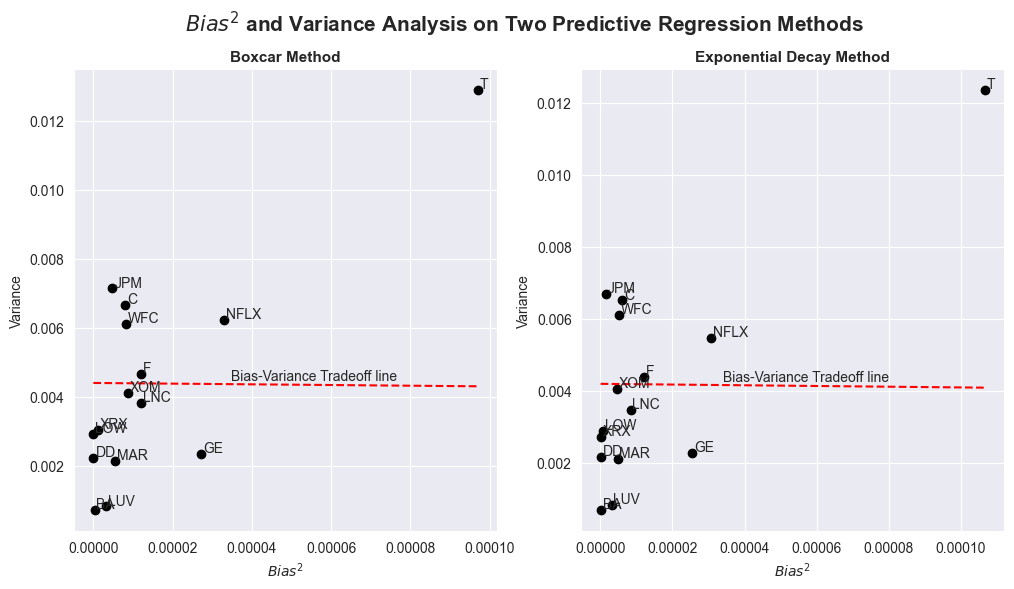

In [27]:
# set figure window
f, ax = plt.subplots(1, 2, figsize = (12, 6))
# plot for boxcar
ax[0].scatter(boxcar[r'$Bias^2$'], boxcar['Variance'], color = "black")
for i in range(len(boxcar.index)):
    ax[0].annotate(boxcar.index[i], (boxcar[r'$Bias^2$'][i], boxcar['Variance'][i]),
                   xytext = (boxcar[r'$Bias^2$'][i] + 5*10**(-7), boxcar['Variance'][i]+ 5*10**(-5)))
# theoretical line
ax[0].plot([boxcar[r'$Bias^2$'].min(), boxcar[r'$Bias^2$'].max()],
           [boxcar['Variance'].mean() + boxcar[r'$Bias^2$'].mean() - boxcar[r'$Bias^2$'].min(),
            boxcar['Variance'].mean() + boxcar[r'$Bias^2$'].mean() - boxcar[r'$Bias^2$'].max()],
           color = "red", linestyle = '--')
ax[0].annotate("Bias-Variance Tradeoff line", (boxcar[r'$Bias^2$'].mean(), boxcar['Variance'].mean()),
               xytext = (boxcar[r'$Bias^2$'].mean() + 2*10**(-5), boxcar['Variance'].mean() + 10**(-4)))
# subplot title
ax[0].set_title("Boxcar Method", fontweight = "bold", fontsize=11)
# x axis ticks and labels
ax[0].set_xlabel(r'$Bias^2$', fontsize=10)
# y axis labels
ax[0].set_ylabel('Variance', fontsize=10)
# plot for decay
ax[1].scatter(decay[r'$Bias^2$'], decay['Variance'], color = "black")
for i in range(len(decay.index)):
    ax[1].annotate(decay.index[i], (decay[r'$Bias^2$'][i], decay['Variance'][i]),
                   xytext = (decay[r'$Bias^2$'][i] + 5*10**(-7), decay['Variance'][i]+ 5*10**(-5)))
# theoretical line
ax[1].plot([decay[r'$Bias^2$'].min(), decay[r'$Bias^2$'].max()],
           [decay['Variance'].mean() + decay[r'$Bias^2$'].mean() - decay[r'$Bias^2$'].min(),
            decay['Variance'].mean() + decay[r'$Bias^2$'].mean() - decay[r'$Bias^2$'].max()],
           color = "red", linestyle = '--')
ax[1].annotate("Bias-Variance Tradeoff line", (decay[r'$Bias^2$'].mean(), decay['Variance'].mean()),
               xytext = (decay[r'$Bias^2$'].mean() + 2*10**(-5), decay['Variance'].mean() + 10**(-4)))
# subplot title
ax[1].set_title("Exponential Decay Method", fontweight = "bold", fontsize=11)
# x axis ticks and labels
ax[1].set_xlabel(r'$Bias^2$', fontsize=10)
# y axis labels
ax[1].set_ylabel('Variance', fontsize=10)
# title
f.suptitle(r'$Bias^2$ and Variance Analysis on Two Predictive Regression Methods', fontsize = 15, fontweight = "bold")
None

The Bias-Variance Tradeoff line was computed using the average mean Bias-squared and mean Variance values across all
15 tickers.
The points under the tradeoff line were considered efficient.
The points over the tradeoff line were considered inefficient.
The regression for ticker "T" was considered highly inefficient.
There were many efficient tickers but "BA" was closest to the origin, with the lowest mean Bias-squared and lowest mean
Variance of all the tickers.

<h3> 4-2. Prediction for "BA" and "T" </h3>

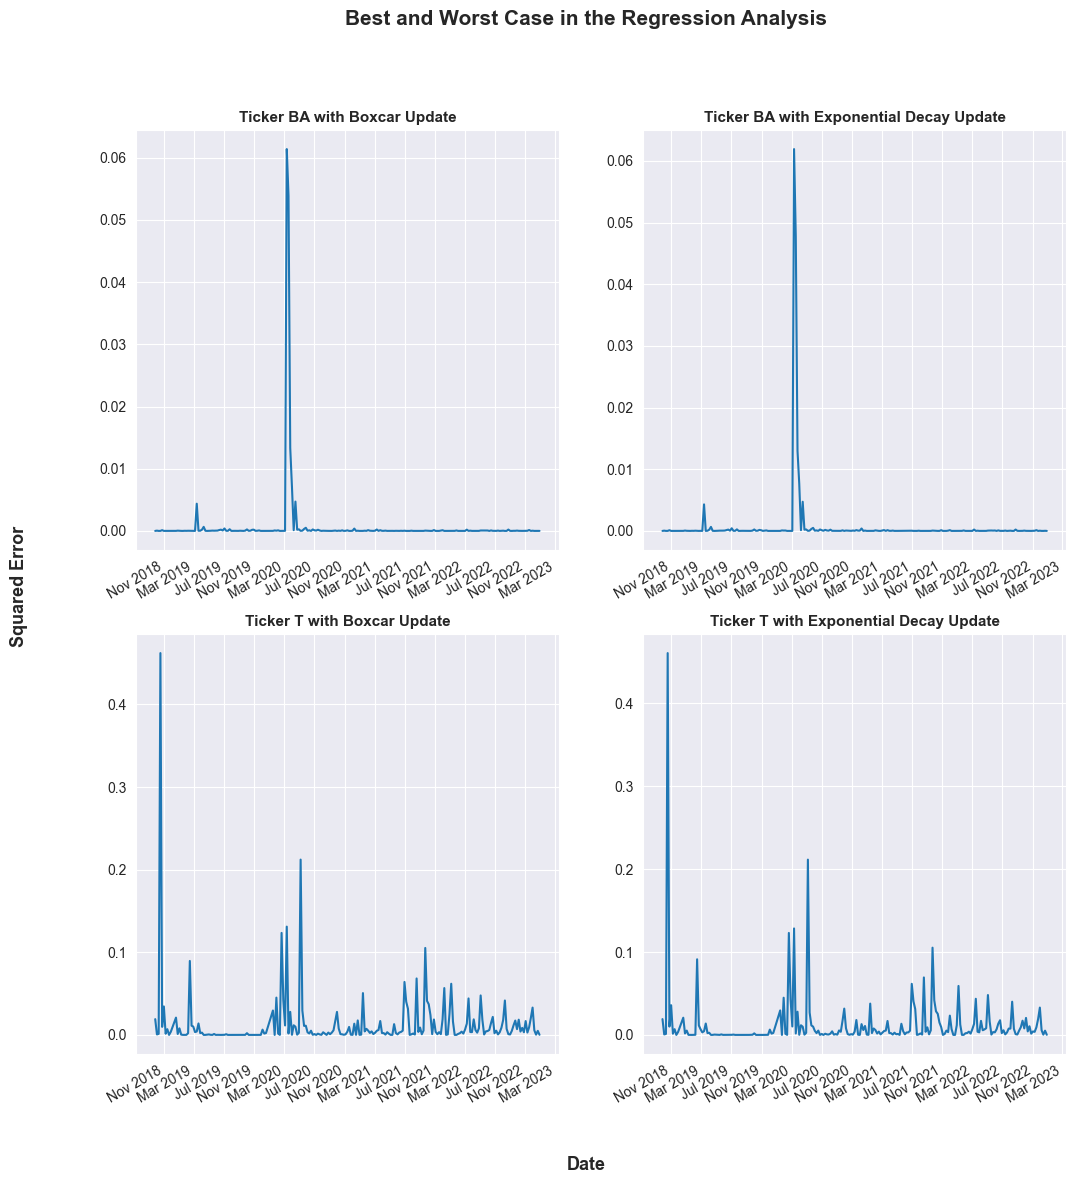

In [28]:
# set figure window
f, ax = plt.subplots(2, 2, figsize = (12, 12))
# best case
# boxcar method
ax[0][0].plot(boxcar_SE['BA'])
# exponential decay method
ax[0][1].plot(decay_SE['BA'])
# worst case
# boxcar method
ax[1][0].plot(boxcar_SE['T'])
# exponential decay method
ax[1][1].plot(decay_SE['T'])
terms = [['BA', 'T'], ['Boxcar', 'Exponential Decay']]
for i in range(2):
    for j in range(2):
        # x tickers
        ax[i][j].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
        ax[i][j].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.setp(ax[i][j].get_xticklabels(), rotation=30, horizontalalignment='right')
        # set subplot title
        ax[i][j].set_title(f'Ticker {terms[0][i]} with {terms[1][j]} Update', fontsize = 11, fontweight = "bold")
f.supxlabel("Date", fontsize = 13, fontweight = "bold")
f.supylabel("Squared Error", fontsize = 13, fontweight = "bold")
f.suptitle("Best and Worst Case in the Regression Analysis", fontsize = 15, fontweight = "bold")
None

Fluctuations in the scaled Squared Error values were compared for the best and worst cases.